In [1]:
import os, sys

# path to access c++ files
sys.path.append(os.getenv("HOME"))

In [3]:
from cunqa import get_QPUs, qraise

family = qraise(10, "00:20:00", simulator = "Aer",  co_located = True)
qpus  = get_QPUs(co_located=True)

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


Requested QPUs with command:
	qraise -n 10 -t 00:20:00 --simulator=Aer --co-located
QPUs ready to work ✅
QPU 291329_603953_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603954_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603955_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603956_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603957_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603958_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603959_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603960_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603961_291329, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 291329_603962_291329, backend: SimpleBackend, simulator: AerSimulator, v

# Examples for optimizations

Before sending a circuit to the QClient, a transpilation process occurs (if not, it is done by the user). This process, in some cases, can take much time and resources, in addition to the sending cost itself. If we were to execute a single circuit once, it shouldn´t be a big problem, but it is when it comes to variational algorithms.

This quantum-classical algorithms require several executions of the same circuit but changing the value of the parameters, which are optimized in the classical part. In order to optimize this, we developed a functionallity that allows the user to upgrade the circuit parameters with no extra transpilations of the circuit, sending to the `QClient` the list of the parameters **ONLY**. This is of much advantage to speed up the computation in the cases in which transpilation takes a significant part of the total time of the simulation.

Let´s see how to work with this feature taking as an example a _Variational Quantum Algorithm_ for state preparation.

We start from a _Hardware Efficient Ansatz_ to build our parametrized circuit:

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

The we need a cost function. We will define a target distribution and measure how far we are from it. We choose to prepare a normal distribution among all the $2^n$ possible outcomes of the circuit.

In [5]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

import pandas as pd
from scipy.stats import entropy, norm

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence
    

In [6]:
num_qubits = 6

num_layers = 3

n_shots = 1e5

### Simply using the `QPU.run()` method

At first we should try the intiutive alternative: upgrading parameters at the QClient, transpiling and sending the whole circuit to the QPU.

In [10]:
from cunqa.qpu import run

def cost_function_run(params):
    n_shots = 1e5
    target_dist = target_distribution(num_qubits)
    
    circuit = ansatz.assign_parameters(params)
    
    result = run(circuit, qpu, shots = n_shots).result
    
    counts = result.counts
    
    return KL_divergence(counts, n_shots, target_dist)

Our cost function updates the parameters given by the optimizer, asigns them to the ansatz and sends the circuit with the transpilation option set `True`. Let´s choose a QPU to work with and go ahead with the optimization:

In [11]:
import numpy as np
import time

qpu = qpus[0]

In [12]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

from scipy.optimize import minimize

i = 0

cost_run = []
individuals_run = []

def callback(xk):
    global i
    e = cost_function_run(xk)
    individuals_run.append(xk)
    cost_run.append(e)
    if i%20 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result_run = minimize(cost_function_run, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info at the end
        'maxiter': 4000   # Limit the number of iterations
    })
tack = time.time()
time_run = tack-tick
print()
print("Total optimization time: ", time_run, " s")
print()

Iteration step 0: f(x) = 5.644885693319627
Iteration step 20: f(x) = 3.245484736905239
Iteration step 40: f(x) = 0.7034749778676445
Iteration step 60: f(x) = 0.5162685170041814
Iteration step 80: f(x) = 0.4483670976555169
Iteration step 100: f(x) = 0.38613242583971913
Iteration step 120: f(x) = 0.1744463264343984
Iteration step 140: f(x) = 0.21276914588591025
Iteration step 160: f(x) = 0.14738098284467196
Iteration step 180: f(x) = 0.11883462391982022
Iteration step 200: f(x) = 0.11467093794207306
Iteration step 220: f(x) = 0.09527011833133982
Iteration step 240: f(x) = 0.07508219178505701
Iteration step 260: f(x) = 0.05264224140918328
Iteration step 280: f(x) = 0.051292321735479283
Iteration step 300: f(x) = 0.04365429834177821
Iteration step 320: f(x) = 0.037999924123866755
Iteration step 340: f(x) = 0.03193604483380519
Iteration step 360: f(x) = 0.028144946022645265
Iteration step 380: f(x) = 0.024965104518625852
Iteration step 400: f(x) = 0.02271386260721605
Iteration step 420: f(x

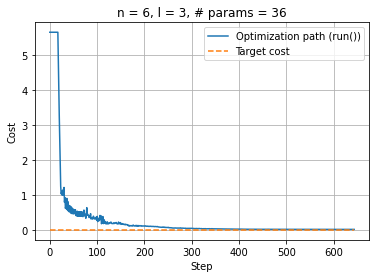

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = optimization_result_run.nfev
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_run_n_{num_qubits}_p_{num_parameters}.png", dpi=200)

### Using `QJob.upgrade_parameters()`

The first step now is to create the `qjob.QJob` object that which parameters we are going to upgrade in each step of the optimization; for that, we must run a circuit with initial parameters in a QPU, the procedure is as we explained above:

In [15]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

circuit = ansatz.assign_parameters(initial_parameters)

qjob = run(circuit, qpu, shots = n_shots)

Now that we have sent to the virtual QPU the transpiled circuit, we can use the method `qjob.QJob.upgrade_parameters()` to change the rotations of the gates:

In [16]:
print("Result with initial_parameters: ")
print(qjob.result.counts)

random_parameters = np.random.uniform(0, 2 * np.pi, num_parameters).tolist()
print(random_parameters)
qjob.upgrade_parameters(random_parameters)

print()
print("Result with random_parameters: ")
print(qjob.result.counts)

Result with initial_parameters: 
{'000000': 100000}
[0.3824035329221435, 5.700759307512278, 2.0414787916088373, 6.203033318042109, 5.563205400719785, 1.4235104244113972, 0.7636133461398414, 3.021698769378253, 2.5959949971542122, 3.3394385545480416, 2.5044569636842, 2.5322648504891743, 1.2378286987325255, 4.791298439428159, 3.161063957591091, 1.135702907222371, 2.1625483331310313, 5.393077328166885, 0.2818103572037159, 0.6200990306564472, 3.438054508930004, 0.34288206671517296, 5.7151702023012225, 1.5061330790646206, 0.05714683456664815, 4.905725319186825, 0.614069949006336, 1.9613985868890422, 4.928007716999347, 4.985215930874576, 3.4164014602670982, 2.339870636262697, 3.958813392875087, 1.010322778272544, 2.0297722062701227, 5.159625358184195]

Result with random_parameters: 
{'000000': 3672, '000001': 2804, '000010': 816, '000011': 2949, '000100': 2460, '000101': 4086, '000110': 1777, '000111': 1577, '001000': 485, '001001': 630, '001010': 306, '001011': 155, '001100': 8059, '001101'

**Important considerations:**

- The method acepts parameters in a `list`, if you have a `numpy.array`, simply apply `.tolist()` to transform it.

- When sending the circuit and setting `transpile=True`, we should be carefull that the transpilation process doesn't condense gates and combine parameters, therefore, if the user wants `cunqa`to transpile, they must set `opt_level=0`.

Note that `qjob.QJob.upgrade_parameters()` is a non-blocking call, as it was `qpu.QPU.run()`.

Now that we are familiar with the procedure, we can design a cost funtion that takes a set of parameters, upgrades the `qjob.QJob`, gets the result and calculates the divergence from the desired distribution:

In [17]:
def cost_function(params):
    n_shots = 100000
    target_dist = target_distribution(num_qubits)
    
    qjob.upgrade_parameters(params.tolist())
    
    counts = qjob.result.counts
    
    return KL_divergence(counts, n_shots, target_dist)


Now we are ready to start our optimization. We will use `scipy.optimize` to minimize the divergence of our result distribution from the target one:

In [18]:
from scipy.optimize import minimize
import time

i = 0

initial_parameters = np.zeros(num_parameters)

cost = []
individuals = []

def callback(xk):
    global i
    e = cost_function(xk)
    individuals.append(xk)
    cost.append(e)
    if i%10 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result = minimize(cost_function, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info during iterations
        'maxiter': 4000     # Limit the number of iterations
    })
tack = time.time()
time_up = tack-tick
print()
print("Total optimization time: ", time_up, " s")

Iteration step 0: f(x) = 4.805426773734427
Iteration step 10: f(x) = 1.243820045942678
Iteration step 20: f(x) = 0.9871947432165984
Iteration step 30: f(x) = 0.6166077461481007
Iteration step 40: f(x) = 0.6199949523780122
Iteration step 50: f(x) = 0.6014506947793149
Iteration step 60: f(x) = 0.5373176605276874
Iteration step 70: f(x) = 0.38559020783278375
Iteration step 80: f(x) = 0.32674676991447527
Iteration step 90: f(x) = 0.22054213583865973
Iteration step 100: f(x) = 0.22184845450694157
Iteration step 110: f(x) = 0.21962337636103163
Iteration step 120: f(x) = 0.19756110872009183
Iteration step 130: f(x) = 0.18861032728563734
Iteration step 140: f(x) = 0.19201619402818795
Iteration step 150: f(x) = 0.15787885743065744
Iteration step 160: f(x) = 0.15752458457575805
Iteration step 170: f(x) = 0.14805786794970865
Iteration step 180: f(x) = 0.1458290988623337
Iteration step 190: f(x) = 0.13442075481701343
Iteration step 200: f(x) = 0.10757435573797045
Iteration step 210: f(x) = 0.10417

We can plot the evolution of the cost function during the optimization:

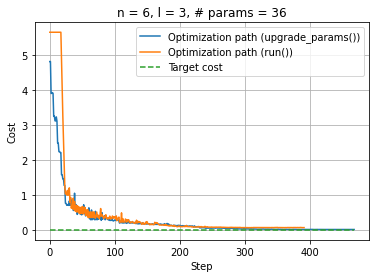

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result.nfev, optimization_result.nfev), cost, label="Optimization path (upgrade_params())")
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = max(optimization_result_run.nfev, optimization_result.nfev)
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_n_{num_qubits}_p_{num_parameters}.png", dpi=200)